In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

returns_filepath='../hurst_results/ret_acum_df.csv'
risk_free_filepath='../distance_data/Rf.csv'
df_returns = pd.read_csv(returns_filepath)
df_rf = pd.read_csv(risk_free_filepath, header=None, names=['Return'])

df_returns['SEMESTER'] = df_returns['SEMESTER'].astype(int)
daily_total_returns_list = []

chained_cumulative_list = []
# This will hold the final value of the previous semester to chain the next one
last_semester_end_value = 1.0 

# Group by semester and process them in order
for semester_num in sorted(df_returns['SEMESTER'].unique()):
    group = df_returns[df_returns['SEMESTER'] == semester_num]
        
    # Get the original cumulative series for the semester (which starts near 1)
    semester_cumulative = group['CC'].copy()
        
    # Chain the returns: multiply this semester's values by the last value of the previous one
    chained_semester_cumulative = semester_cumulative * last_semester_end_value
        
    # Append the corrected series to our list
    chained_cumulative_list.append(chained_semester_cumulative)
        
    # Update the last value for the next iteration, ensuring it's a valid number
    if not chained_semester_cumulative.empty:
        last_semester_end_value = chained_semester_cumulative.iloc[-1]

    # Concatenate all the chained series into one continuous series
    continuous_cumulative_total_return = pd.concat(chained_cumulative_list)

# --- Step 3: Calculate Continuous Daily Excess Returns ---
    
# First, calculate daily total returns from the corrected continuous cumulative series
continuous_daily_total_returns = continuous_cumulative_total_return.pct_change()
# The very first return is the starting cumulative value minus 1
continuous_daily_total_returns.iloc[0] = continuous_cumulative_total_return.iloc[0] - 1

continuous_daily_total_returns

0       0.000000
1       0.001235
2       0.001923
3      -0.005680
4       0.000000
          ...   
6120         NaN
6121         NaN
6122         NaN
6123         NaN
6124         NaN
Name: CC, Length: 6173, dtype: float64

Successfully loaded data files.
Plot saved as 'cumulative_excess_returns_from_Rf.png'


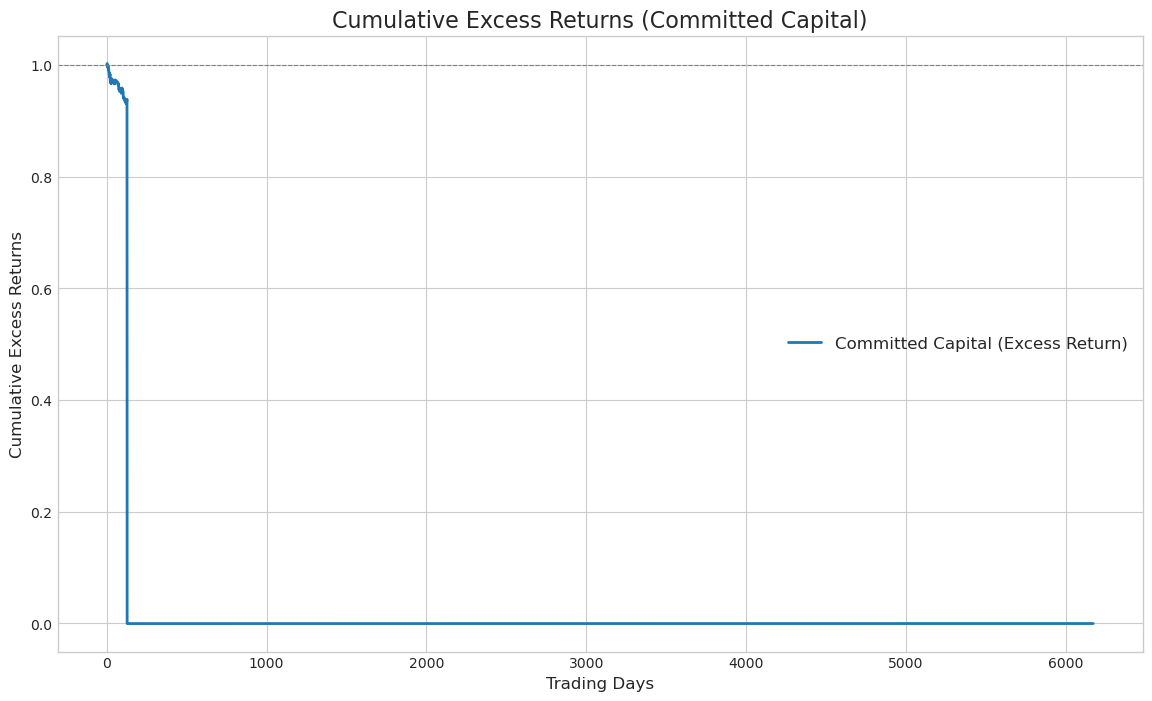

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generate_cumulative_excess_return_chart(returns_filepath, risk_free_filepath, output_image_path):
    """
    Loads strategy and risk-free data, calculates the continuous cumulative
    excess return for the 'Committed Capital' strategy, and generates a plot.

    Args:
        returns_filepath (str): Path to the ret_acum_df.csv file.
        risk_free_filepath (str): Path to the Rf.csv file.
        output_image_path (str): Path to save the output chart image.
    """
    # --- Step 1: Load the data ---
    try:
        df_returns = pd.read_csv(returns_filepath)
        # Load Rf.csv, assuming it has no header and is a single column
        df_rf = pd.read_csv(risk_free_filepath, header=None, names=['Return'])
        print("Successfully loaded data files.")
    except FileNotFoundError as e:
        print(f"Error: Could not find a required file. {e}")
        return

    # --- Step 2: Reconstruct Daily Total Returns for the 'CC' strategy ---
    df_returns['SEMESTER'] = df_returns['SEMESTER'].astype(int)
    daily_total_returns_list = []
    
    # Group by semester to handle the resets correctly
    for _, group in df_returns.groupby('SEMESTER'):
        cumulative_series = group['CC'].reset_index(drop=True)
        # Calculate daily returns from the cumulative series
        daily_r = cumulative_series.pct_change().fillna(cumulative_series.iloc[0] - 1)
        daily_total_returns_list.append(daily_r)

    # Concatenate into a single continuous series of daily returns
    continuous_daily_total_returns = pd.concat(daily_total_returns_list).reset_index(drop=True)

    # --- Step 3: Align data and calculate Daily Excess Returns ---
    
    # Create a combined DataFrame, aligning by index
    # Ensure the risk-free DataFrame has the same index length
    combined_df = pd.DataFrame({
        'Total_Return': continuous_daily_total_returns
    })
    combined_df['Risk_Free_Rate'] = df_rf['Return']
    
    # Calculate daily excess return
    combined_df['Excess_Return'] = combined_df['Total_Return'] - combined_df['Risk_Free_Rate']

    # --- Step 4: Calculate the final, continuous cumulative excess return ---
    cumulative_excess_return = (1 + combined_df['Excess_Return']).cumprod()

    # --- Step 5: Generate the plot ---
    if cumulative_excess_return.empty:
        print("No trading data available to generate a plot.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    ax.plot(range(len(cumulative_excess_return)), cumulative_excess_return, label='Committed Capital (Excess Return)', linewidth=2)

    ax.set_title('Cumulative Excess Returns (Committed Capital)', fontsize=16)
    ax.set_xlabel('Trading Days', fontsize=12)
    ax.set_ylabel('Cumulative Excess Returns', fontsize=12)
    ax.legend(fontsize=12)
    ax.axhline(y=1, color='grey', linestyle='--', linewidth=0.8)

    # Save the figure to a PNG file
    plt.savefig(output_image_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved as '{output_image_path}'")
    
    # The line below would display the plot. It is commented out as requested.
    plt.show()


# --- Execute the function with your file paths ---
generate_cumulative_excess_return_chart(
    returns_filepath='../hurst_results/ret_acum_df.csv',
    risk_free_filepath='../distance_data/Rf.csv',
    output_image_path='cumulative_excess_returns_from_Rf.png'
)